<a href="https://colab.research.google.com/github/MHosseinHashemi/Image_Sim/blob/main/Image_Simmilarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import functools

In [2]:
(train_ds, valid_ds), info = tfds.load("oxford_flowers102", split=["train", "validation"], as_supervised=True, with_info=True)

In [3]:
IMG_WIDTH = IMG_HEIGHT = 256

In [4]:
CLASSES_TO_CONSIDER = list(range(10)) # Only the first 10 classes

In [5]:
# A function to Prep the images
def preprocess_image(image, label, height, width):
    image = tf.image.resize_with_crop_or_pad(image, target_height=height, target_width=width)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [6]:
# A function to filter out unwanted labels ! You should remove it after test training ....
def filter_by_classes(img, label):
  # Only picks the selected labels
  bools = tf.equal(label, CLASSES_TO_CONSIDER)
  return tf.reduce_any(bools)

In [7]:
# Create a new function to prep the
partial_preprocess_image = functools.partial(preprocess_image, height=IMG_HEIGHT, width=IMG_WIDTH)
train_ds = train_ds.filter(filter_by_classes).map(partial_preprocess_image).cache().shuffle(buffer_size=1000)
valid_ds = valid_ds.filter(filter_by_classes).map(partial_preprocess_image).cache().shuffle(buffer_size=1000)

In [8]:
def get_x_y_from_ds(ds):
    x, y = [], []
    for img, label in ds.cache().as_numpy_iterator():
        x.append(img)
        y.append(label)

    return np.array(x), np.array(y)

In [9]:
x_train, y_train = get_x_y_from_ds(train_ds)

In [10]:
x_test, y_test = get_x_y_from_ds(valid_ds)

In [11]:
print(f"number of {len(x_train)} samples\nnumber of {len(y_train)} samples\nnumber of {len(x_test)} samples\nnumber of {len(y_test)} samples")

number of 100 samples
number of 100 samples
number of 100 samples
number of 100 samples


In [12]:
# Model
MODEL_URL = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2"

model = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    hub.KerasLayer(MODEL_URL, trainable=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

model.build([None, IMG_HEIGHT, IMG_WIDTH, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              20331360  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 lambda (Lambda)             (None, 256)               0         
                                                        

In [13]:
from collections import defaultdict
import random

def get_training_batch(images, labels, batch_size=128, n_examples_per_class=4):
    examples_per_class = defaultdict(list)
    for x, y in zip(images, labels):
        examples_per_class[y].append(x)

    while True:
        batch_X, batch_y = [], []
        while len(batch_X) < batch_size:
            for cls, examples in examples_per_class.items():
                n_sample = min(n_examples_per_class, (batch_size - len(batch_X)))
                if n_sample == 0:
                    break
                samples = random.sample(examples, k=n_sample)
                batch_X.extend(samples)
                batch_y.extend([cls] * len(samples))

        yield np.array(batch_X), np.array(batch_y)

In [14]:
# !pip install tensorflow_addons

In [18]:
bs = 24
n_examples_per_class = 3
initial_lr = 0.0001
epochs = 80
import tensorflow_addons as tfa

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
                         loss=tfa.losses.TripletSemiHardLoss())

history = model.fit(get_training_batch(images=x_train, labels=y_train, batch_size=bs, n_examples_per_class=n_examples_per_class),
                               epochs=epochs,
                               steps_per_epoch=len(x_train)//bs,
                               validation_data=(x_test, y_test),
                               validation_batch_size=bs,
                              )

Epoch 1/80
4/4 [==============================] - 99s 1s/step - loss: 0.8097 - val_loss: nan
Epoch 2/80
4/4 [==============================] - 2s 597ms/step - loss: 0.7671 - val_loss: nan
Epoch 3/80
4/4 [==============================] - 2s 594ms/step - loss: 0.6984 - val_loss: nan
Epoch 4/80
4/4 [==============================] - 2s 595ms/step - loss: 0.6572 - val_loss: nan
Epoch 5/80
4/4 [==============================] - 2s 652ms/step - loss: 0.6052 - val_loss: nan
Epoch 6/80
4/4 [==============================] - 2s 656ms/step - loss: 0.5349 - val_loss: nan
Epoch 7/80
4/4 [==============================] - 2s 600ms/step - loss: 0.4920 - val_loss: nan
Epoch 8/80
4/4 [==============================] - 2s 648ms/step - loss: 0.4238 - val_loss: nan
Epoch 9/80
4/4 [==============================] - 2s 606ms/step - loss: 0.3766 - val_loss: nan
Epoch 10/80
4/4 [==============================] - 2s 649ms/step - loss: 0.3112 - val_loss: nan
Epoch 11/80
4/4 [==============================] - 

In [19]:
print("Done")

Done


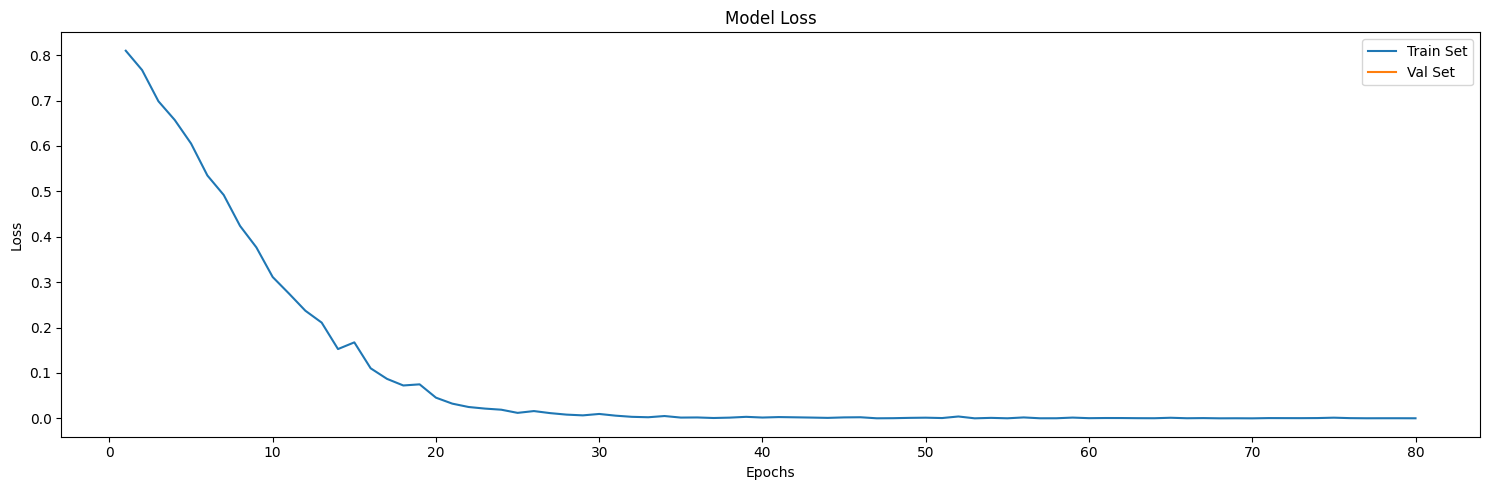

In [31]:
# plot model performance


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# Logs

###### - 30 Epocsh Seems to be enough
###### - 32 batch is the maximum number
###### - Validation Loss is not a Number !?!?!